
Shapes: X_train=(18105, 273), y_train=(18105, 3), X_test=(3520, 273), y_test=(3520, 3)

=== ORIGINAL MODEL ===

Epoch 1/200


283/283 [==============================] - 1s 2ms/step - loss: 1.0029 - accuracy: 0.5387 - val_loss: 0.9969 - val_accuracy: 0.5463
Epoch 2/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9905 - accuracy: 0.5450 - val_loss: 0.9887 - val_accuracy: 0.5463
Epoch 3/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9812 - accuracy: 0.5450 - val_loss: 0.9792 - val_accuracy: 0.5463
Epoch 4/200
283/283 [==============================] - 0s 2ms/step - loss: 0.9693 - accuracy: 0.5450 - val_loss: 0.9693 - val_accuracy: 0.5463
Epoch 5/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9542 - accuracy: 0.5443 - val_loss: 0.9539 - val_accuracy: 0.5474
Epoch 6/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9365 - accuracy: 0.5481 - val_loss: 0.9370 - val_accuracy: 0.5543
Epoch 7/200
283/283 [======

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 0s 3ms/step - loss: 1.2390 - accuracy: 0.4719 - val_loss: 1.1139 - val_accuracy: 0.5460 - lr: 5.0000e-04
Epoch 3/100
142/142 [==============================] - 0s 3ms/step - loss: 1.1735 - accuracy: 0.4997 - val_loss: 1.0764 - val_accuracy: 0.5554 - lr: 5.0000e-04
Epoch 4/100
142/142 [==============================] - 0s 3ms/step - loss: 1.1239 - accuracy: 0.5196 - val_loss: 1.0503 - val_accuracy: 0.5662 - lr: 5.0000e-04
Epoch 5/100
142/142 [==============================] - 0s 3ms/step - loss: 1.0806 - accuracy: 0.5398 - val_loss: 1.0266 - val_accuracy: 0.5688 - lr: 5.0000e-04
Epoch 6/100
142/142 [==============================] - 0s 3ms/step - loss: 1.0514 - accuracy: 0.5586 - val_loss: 1.0077 - val_accuracy: 0.5835 - lr: 5.0000e-04
Epoch 7/100
142/142 [==============================] - 0s 3ms/step - loss: 1.0210 - accuracy: 0.5724 - val_loss: 0.9905 - val_accuracy: 0.5895 - lr: 5.0000e-04
Epoch 8/100
142/142 [==============================]

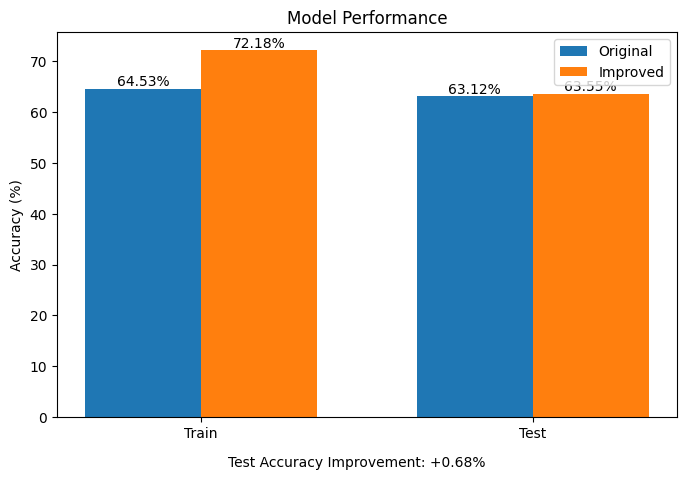

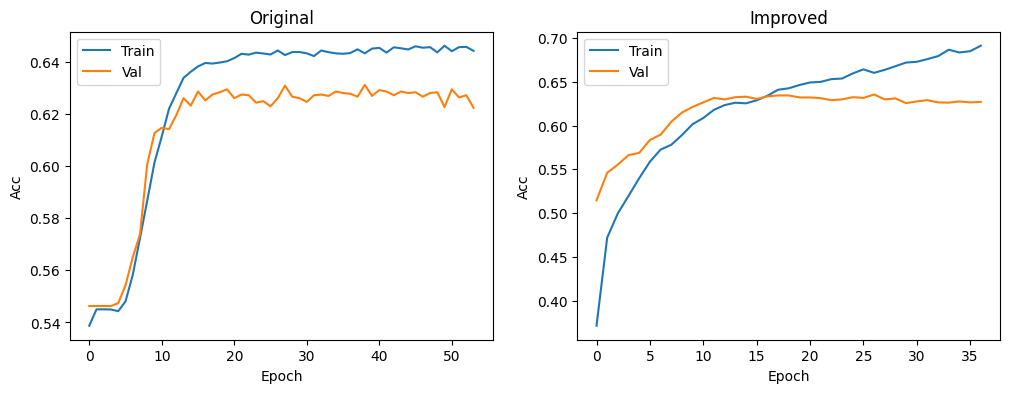

In [1]:
### Cell 1: Imports & Configuration
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import (Dense, Lambda, Activation, Input,
                                     Dropout, BatchNormalization)
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split

# Constants
AMINO_ACIDS = ['A','R','N','D','C','Q','E','G','H','I',
               'L','K','M','F','P','S','T','W','Y','V']
SPACER_IDX = 20             # index for padding
LABEL_MAP = {'h':0, 'e':1, '_':2}  # Q3 labels

### Cell 2: Data Loading & Preprocessing
def parse_data(file_path):
    sequences = []
    current_seq = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            if line in ('<>', '<end>'):
                if current_seq:
                    sequences.append(current_seq)
                current_seq = []
                continue
            parts = line.split()
            if len(parts) == 2 and parts[1].lower() in LABEL_MAP:
                current_seq.append((parts[0].upper(), parts[1].lower()))
    return sequences


def create_dataset(sequences):
    X, y = [], []
    for seq in sequences:
        L = len(seq)
        for i in range(L):
            window = []
            for j in range(i-6, i+7):
                window.append(
                    SPACER_IDX if j<0 or j>=L else AMINO_ACIDS.index(seq[j][0])
                )
            one_hot = np.zeros((13,21), dtype=np.float32)
            for pos, idx in enumerate(window):
                one_hot[pos, idx] = 1.0
            X.append(one_hot.flatten())
            y.append(LABEL_MAP[seq[i][1]])
    X_arr = np.array(X)
    y_cat = tf.keras.utils.to_categorical(y, num_classes=3)
    return X_arr, y_cat

### Cell 3: Model Architectures
def create_original_model():
    model = Sequential([
        Dense(40, activation='sigmoid', input_dim=273),
        Dense(3, activation='linear'),
        Lambda(lambda x: x/2),
        Activation('softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=0.1),
        metrics=['accuracy']
    )
    return model


def create_improved_model():
    inp = Input(shape=(273,))
    x = Dense(64, kernel_regularizer=l2(0.001))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(3, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model

### Cell 4: Evaluation & Plotting Utilities
def print_metrics(y_true, y_pred, name="Dataset"):
    y_true_lbl = np.argmax(y_true, axis=1)
    y_pred_lbl = np.argmax(y_pred, axis=1)
    acc = np.mean(y_true_lbl == y_pred_lbl)
    print(f"\n{name} Q3 Accuracy: {acc*100:.2f}%")
    print("Matthews CC:")
    for lbl, idx in LABEL_MAP.items():
        mcc = matthews_corrcoef(y_true_lbl==idx, y_pred_lbl==idx)
        print(f"C_{lbl}: {mcc:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_lbl, y_pred_lbl))
    return acc


def plot_comparison(orig_metrics, imp_metrics):
    labels = ['Train', 'Test']
    orig_vals = [orig_metrics['train_acc'], orig_metrics['test_acc']]
    imp_vals  = [imp_metrics['train_acc'], imp_metrics['test_acc']]
    x = np.arange(len(labels))
    width=0.35
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x-width/2, orig_vals, width, label='Original')
    ax.bar(x+width/2, imp_vals, width, label='Improved')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Performance')
    ax.legend()
    for bars in [ax.containers[0], ax.containers[1]]:
        for bar in bars:
            ax.annotate(f'{bar.get_height():.2f}%',
                        xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom')
    improvement = (imp_metrics['test_acc']-orig_metrics['test_acc'])/orig_metrics['test_acc']*100
    plt.figtext(0.5, 0.01, f'Test Accuracy Improvement: +{improvement:.2f}%', ha='center')
    plt.show()


def plot_history(h1, h2):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
    ax1.plot(h1.history['accuracy'], label='Train')
    ax1.plot(h1.history['val_accuracy'], label='Val')
    ax1.set_title('Original')
    ax2.plot(h2.history['accuracy'], label='Train')
    ax2.plot(h2.history['val_accuracy'], label='Val')
    ax2.set_title('Improved')
    for ax in (ax1, ax2): ax.set_xlabel('Epoch'); ax.set_ylabel('Acc'); ax.legend()
    plt.show()

### Cell 5: Run Code1 (Original vs Improved full train/test)
# Load data
train_seqs = parse_data('protein-secondary-structure.train.txt')
test_seqs  = parse_data('protein-secondary-structure.test.txt')
X_train, y_train = create_dataset(train_seqs)
X_test,  y_test  = create_dataset(test_seqs)
assert X_train.shape[1]==273
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")

# Train Original
print("\n=== ORIGINAL MODEL ===")
orig_model = create_original_model()
e1 = EarlyStopping('val_accuracy', patience=15, restore_best_weights=True)
start = time.time()
history1 = orig_model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200, batch_size=64, callbacks=[e1], verbose=1)
orig_time = time.time()-start

# Evaluate Original
train_pred1 = orig_model.predict(X_train)
test_pred1  = orig_model.predict(X_test)
orig_metrics={'train_acc':print_metrics(y_train,train_pred1)*100,
              'test_acc': print_metrics(y_test, test_pred1)*100}

# Train Improved
print("\n=== IMPROVED MODEL ===")
imp_model = create_improved_model()
cb_list = [EarlyStopping('val_accuracy',patience=10,restore_best_weights=True),
           ModelCheckpoint('best_model.h5','val_accuracy',save_best_only=True),
           ReduceLROnPlateau('val_loss',factor=0.5,patience=5,min_lr=1e-6)]
start = time.time()
history2 = imp_model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100, batch_size=128, callbacks=cb_list, verbose=1)
imp_time = time.time()-start

# Evaluate Improved
train_pred2 = imp_model.predict(X_train)
test_pred2  = imp_model.predict(X_test)
imp_metrics={'train_acc':print_metrics(y_train,train_pred2)*100,
             'test_acc': print_metrics(y_test, test_pred2)*100}

# Time Comparison
print(f"\nOriginal train time: {orig_time:.2f}s, Improved train time: {imp_time:.2f}s")

# Performance Plots
plot_comparison(orig_metrics, imp_metrics)
plot_history(history1, history2)

Full dataset: X=(18105, 273), y=(18105, 3)
Train: (14484, 273), Hold-out: (3621, 273)
--- Original Model on Split ---
114/114 [==============================] - 0s 790us/step

Train (Original) Q3 Accuracy: 64.71%
Matthews CC:
C_h: 0.378
C_e: 0.372
C__: 0.407
Confusion Matrix:
[[1765  418 1498]
 [ 455 1283 1171]
 [ 876  693 6325]]

Hold-out (Original) Q3 Accuracy: 63.82%
Matthews CC:
C_h: 0.371
C_e: 0.352
C__: 0.394
Confusion Matrix:
[[ 449  110  361]
 [ 119  313  295]
 [ 240  185 1549]]
--- Improved Model on Split ---
114/114 [==============================] - 0s 921us/step

Train (Improved) Q3 Accuracy: 72.45%
Matthews CC:
C_h: 0.554
C_e: 0.470
C__: 0.535
Confusion Matrix:
[[2416  214 1051]
 [ 441 1326 1142]
 [ 723  419 6752]]

Hold-out (Improved) Q3 Accuracy: 71.09%
Matthews CC:
C_h: 0.544
C_e: 0.435
C__: 0.510
Confusion Matrix:
[[ 611   57  252]
 [ 113  316  298]
 [ 206  121 1647]]


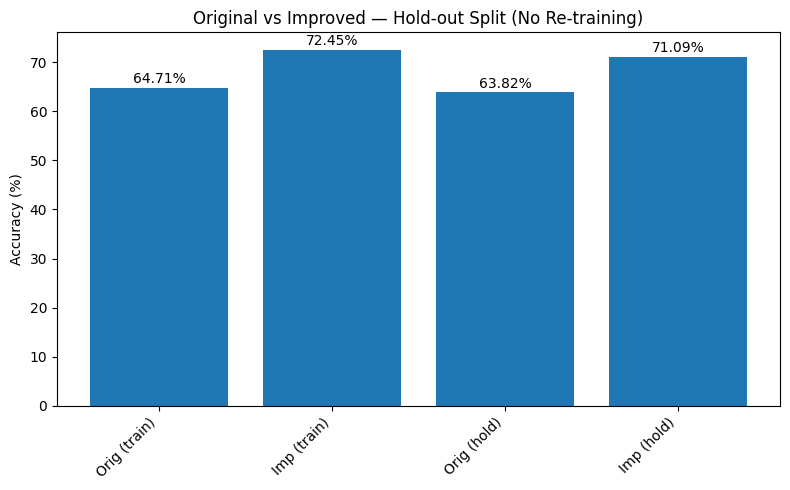

In [3]:
full_seqs = parse_data('protein-secondary-structure.train.txt')
X_full, y_full = create_dataset(full_seqs)
print(f"Full dataset: X={X_full.shape}, y={y_full.shape}")
strat = np.argmax(y_full, axis=1)
X_tr, X_ho, y_tr, y_ho = train_test_split(
    X_full, y_full,
    test_size=0.20,
    random_state=42,
    stratify=strat
)
print(f"Train: {X_tr.shape}, Hold-out: {X_ho.shape}")

# Evaluate Original (previously trained on full train/test)
print("--- Original Model on Split ---")
train_pred_o_split = orig_model.predict(X_tr)
hold_pred_o_split  = orig_model.predict(X_ho)
train_acc_o_split = print_metrics(y_tr, train_pred_o_split, "Train (Original)")
hold_acc_o_split  = print_metrics(y_ho,  hold_pred_o_split,  "Hold-out (Original)")

# Evaluate Improved (previously trained on full train/test)
print("--- Improved Model on Split ---")
train_pred_i_split = imp_model.predict(X_tr)
hold_pred_i_split  = imp_model.predict(X_ho)
train_acc_i_split = print_metrics(y_tr, train_pred_i_split, "Train (Improved)")
hold_acc_i_split  = print_metrics(y_ho,  hold_pred_i_split,  "Hold-out (Improved)")

# Comparison Plot
labels = ['Orig (train)','Imp (train)','Orig (hold)','Imp (hold)']
values = [train_acc_o_split*100,
          train_acc_i_split*100,
          hold_acc_o_split*100,
          hold_acc_i_split*100]
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(x, values)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Original vs Improved — Hold-out Split (No Re-training)')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.2f}%', ha='center')
plt.tight_layout()
plt.show()


In [ ]:
### Cell 7: Optimized SVM Implementation with Progress Tracking

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Add progress bar

# Preprocess data with feature scaling (show progress)
print("Scaling features...")
scaler = StandardScaler()
with tqdm(total=2, desc='Scaling Progress') as pbar:
    X_train_scaled = scaler.fit_transform(X_train)
    pbar.update(1)
    X_test_scaled = scaler.transform(X_test)
    pbar.update(1)

# Convert labels
print("Preparing labels...")
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Create optimized SVM model
svm_model = SVC(
    C=10, 
    gamma='scale',  # More efficient than fixed gamma
    kernel='rbf',
    class_weight='balanced',
    random_state=42,
    verbose=True  # Enable internal progress reporting
)

# Train with progress tracking
print("\n=== SVM MODEL TRAINING ===")
start_time = time.time()
svm_model.fit(X_train_scaled, y_train_labels)
svm_time = time.time() - start_time
print(f"\nSVM training completed in {svm_time:.2f} seconds")

# Generate predictions in batches to avoid memory issues
def predict_in_batches(model, X, batch_size=1000):
    n_samples = X.shape[0]
    predictions = []
    print(f"Predicting in batches of {batch_size}...")
    for i in tqdm(range(0, n_samples, batch_size)):
        batch = X[i:i+batch_size]
        predictions.append(model.predict(batch))
    return np.concatenate(predictions)

# Get predictions
print("\n=== GENERATING PREDICTIONS ===")
svm_train_pred = predict_in_batches(svm_model, X_train_scaled)
svm_test_pred = predict_in_batches(svm_model, X_test_scaled)

# Evaluate performance
print("\n=== SVM MODEL EVALUATION ===")
svm_metrics = {
    'train_acc': accuracy_score(y_train_labels, svm_train_pred) * 100,
    'test_acc': accuracy_score(y_test_labels, svm_test_pred) * 100
}

print(f"\nSVM Train Accuracy: {svm_metrics['train_acc']:.2f}%")
print(f"SVM Test Accuracy: {svm_metrics['test_acc']:.2f}%")

# Comparison plot
models = ['Original NN', 'Improved NN', 'SVM']
test_accs = [orig_metrics['test_acc'], imp_metrics['test_acc'], svm_metrics['test_acc']]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.ylim(60, 80)

# Add accuracy labels
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height-3,
             f'{acc:.2f}%', ha='center', va='top', 
             color='white', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()